# Project: Retinal vessel segmentation

The segmentation of retinal blood vessels from eye fundus images is of great significance for early diagnosis of eye-related diseases such as diabetes and hypertension.

The goal of this project is to read an eye fundus image like the following:
![](https://dlsi.ua.es/~pertusa/tvainput21.png)

And extract the blood vessels as can be seen in the corresponding ground-truth sample:

![](https://dlsi.ua.es/~pertusa/tvagt21.png)

All the images for this project are extracted from the [Drive](https://drive.grand-challenge.org) dataset.

For this task you can use any computer vision technique **except by deep neural networks, that are not allowed in this project**.

## Implementation

To begin with the project, first download from moodle the folder with all the images and upload it to google drive.

Then, import the following libraries (you can add more):

In [ ]:
import os
from google.colab import drive
import cv2 as cv

drive.mount('/content/drive')

%matplotlib inline
from matplotlib import pyplot as plt

db_path =  "/content/drive/MyDrive/TVAProject"

Now you should edit the following function to segment the image and return the obtained segmentation. This is only a simple (basic) skeleton that obviously is not performing well. Your project's goal is basically to complete this function. You can read the attached papers in Moodle to get ideas for the segmentation.

In [ ]:
def vessel_segmentation(input_image):

    img = cv.imread(input_image, cv.IMREAD_GRAYSCALE)

    # TODO: Here it goes your segmentation algorithm. A basic threholding is shown as example.
    th, segmented_image = cv.threshold(img, 128, 255, cv.THRESH_BINARY)

    return segmented_image

Your project will be evaluated with the Intersection over Union (IoU) metric, commonly used in segmentation tasks. This is the function to read a ground truth image and return the IoU considering your segmented image.

In [ ]:
def single_IoU(img_name):

    # Apply segmentation
    input_img = os.path.join(db_path, 'input', img_name)
    obtained = vessel_segmentation(input_img)

    # Path of the target (ground truth) image
    path_target = os.path.join(db_path, 'gt', img_name)
    solution = cv.imread(path_target, cv.IMREAD_GRAYSCALE)

    # Show obtained results
    plt.imshow(obtained, cmap=plt.get_cmap('gray'))
    plt.show()

    # IoU calculation
    intersectionAB = cv.countNonZero(obtained & solution)
    unionAB = cv.countNonZero(obtained | solution)
    score = intersectionAB / unionAB
    print("Image {} - IoU={}".format(path_input, score))

    return score

This is the evaluation method that reads all the images from the input folder and gets the mean IoU for all of them. This is the score of your project, the higher the better.

In [ ]:

meanIoU=0

path_input = os.path.join(db_path, 'input')

# List images in input folder
imgs = [f for f in os.listdir(path_input) if f.endswith('.png')]
print(imgs)

# For each image
for img in imgs:
    meanIoU += single_IoU(img)

# Average
meanIoU /= len(imgs)
print("------------------------------------")
print("Mean IoU={}".format(meanIoU))


In [30]:
%%writefile fov_mask.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Optional, Tuple, Union, Literal

import numpy as np
import cv2 as cv

Array = np.ndarray


@dataclass
class FOVMaskDebug:
    """Optional debug outputs to inspect intermediate steps."""
    green_or_gray: Array
    blurred: Array
    otsu: Array
    candidate_chosen: Array
    after_morph: Array
    largest_cc: Array
    filled: Array
    convex_hull: Array
    ellipse_mask: Array
    final: Array
    chosen_inverted: bool
    scores: Dict[str, float]
    ellipse_used: bool
    ellipse_reason: str


def _to_uint8(gray: Array) -> Array:
    if gray.dtype == np.uint8:
        return gray
    g = gray.astype(np.float32)
    g = g - g.min()
    denom = (g.max() - g.min()) if (g.max() - g.min()) > 1e-6 else 1.0
    return (255.0 * g / denom).clip(0, 255).astype(np.uint8)


def _to_gray_or_green(img: Array) -> Array:
    """
    Convert input (BGR/RGB/GRAY) to a single-channel image.
    For fundus images, green channel usually gives best contrast.
    """
    if img is None:
        raise ValueError("Input image is None.")
    if img.ndim == 2:
        gray = img
    elif img.ndim == 3 and img.shape[2] >= 3:
        # OpenCV loads as BGR by default
        gray = img[:, :, 1]  # green channel
    else:
        raise ValueError(f"Unsupported image shape: {img.shape}")
    return _to_uint8(gray)


def _ensure_odd(k: int) -> int:
    k = int(k)
    if k < 1:
        k = 1
    if k % 2 == 0:
        k += 1
    return k


def _auto_ksizes(h: int, w: int) -> Tuple[int, int]:
    """
    Auto choose morphology kernel sizes based on image diagonal.
    Tuned to be "safe" for common fundus sizes (e.g., DRIVE 768x584).
    """
    diag = float(np.hypot(h, w))
    close_k = _ensure_odd(int(round(diag * 0.035)))  # ~33 for DRIVE
    open_k = _ensure_odd(int(round(diag * 0.012)))   # ~11 for DRIVE
    close_k = max(close_k, 25)
    open_k = max(open_k, 9)
    return close_k, open_k


def _morph_cleanup(mask: Array, close_ksize: int, open_ksize: int) -> Array:
    """Close gaps then open to remove specks."""
    close_ksize = _ensure_odd(close_ksize)
    open_ksize = _ensure_odd(open_ksize)

    close_k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (close_ksize, close_ksize))
    open_k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (open_ksize, open_ksize))

    m = cv.morphologyEx(mask, cv.MORPH_CLOSE, close_k)
    m = cv.morphologyEx(m, cv.MORPH_OPEN, open_k)
    return m


def _largest_connected_component(mask: Array) -> Array:
    """Return a binary mask (0/255) containing only the largest foreground CC."""
    m = (mask > 0).astype(np.uint8)
    num, labels, stats, _ = cv.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        return np.zeros_like(mask, dtype=np.uint8)

    areas = stats[1:, cv.CC_STAT_AREA]
    best_idx = 1 + int(np.argmax(areas))
    out = np.zeros_like(mask, dtype=np.uint8)
    out[labels == best_idx] = 255
    return out


def _fill_holes(mask: Array) -> Array:
    """
    Fill holes inside a binary object using flood-fill on the background.
    Input/Output are 0/255 uint8.
    More robust than using only (0,0) as seed.
    """
    m = (mask > 0).astype(np.uint8) * 255
    h, w = m.shape[:2]
    if h == 0 or w == 0:
        return m

    # find a background seed on the border
    border_coords = []
    border_coords += [(0, x) for x in range(w)]
    border_coords += [(h - 1, x) for x in range(w)]
    border_coords += [(y, 0) for y in range(h)]
    border_coords += [(y, w - 1) for y in range(h)]

    seed = None
    for (yy, xx) in border_coords:
        if m[yy, xx] == 0:
            seed = (xx, yy)  # floodFill uses (x,y)
            break
    if seed is None:
        # mask covers the whole border; nothing to flood-fill safely
        return m

    inv = cv.bitwise_not(m)
    ff = inv.copy()
    flood_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)
    cv.floodFill(ff, flood_mask, seedPoint=seed, newVal=0)

    holes = (ff > 0).astype(np.uint8) * 255
    filled = cv.bitwise_or(m, holes)
    return filled


def _convex_hull(mask: Array) -> Array:
    """Return convex hull of the largest object as 0/255 mask."""
    m = (mask > 0).astype(np.uint8) * 255
    contours, _ = cv.findContours(m, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros_like(m, dtype=np.uint8)

    cnt = max(contours, key=cv.contourArea)
    hull = cv.convexHull(cnt)
    out = np.zeros_like(m, dtype=np.uint8)
    cv.drawContours(out, [hull], -1, 255, thickness=cv.FILLED)
    return out


def _candidate_score(candidate_mask: Array) -> float:
    """
    Score a candidate FOV mask.
    Heuristics (good FOV):
      - large area but not the whole image
      - centered
      - low border contact
      - reasonably compact
    """
    m = (candidate_mask > 0).astype(np.uint8)
    h, w = m.shape[:2]
    area = float(m.sum())
    area_ratio = area / float(h * w)

    if area < 10:
        return -1e9

    border = np.concatenate([m[0, :], m[-1, :], m[:, 0], m[:, -1]])
    border_ratio = float(border.mean())

    ys, xs = np.where(m > 0)
    cy, cx = float(np.mean(ys)), float(np.mean(xs))
    center_dist = np.sqrt((cy - (h / 2.0)) ** 2 + (cx - (w / 2.0)) ** 2)
    center_dist_norm = center_dist / np.sqrt((h / 2.0) ** 2 + (w / 2.0) ** 2)

    circ = 0.0
    m255 = (m * 255).astype(np.uint8)
    contours, _ = cv.findContours(m255, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv.contourArea)
        A = float(cv.contourArea(cnt))
        P = float(cv.arcLength(cnt, True))
        circ = (4.0 * np.pi * A) / (P * P + 1e-6)

    area_penalty = 0.6 if (area_ratio < 0.10 or area_ratio > 0.98) else 0.0

    score = (
        + 1.5 * area_ratio
        - 2.0 * border_ratio
        - 0.8 * center_dist_norm
        + 0.4 * circ
        - area_penalty
    )
    return float(score)


def _fit_ellipse_mask_from_contour(mask: Array, scale: float = 1.02) -> Tuple[Array, bool, str]:
    """
    Fit an ellipse to the outer contour and return an ellipse mask.
    scale > 1 expands ellipse slightly (useful to recover small border bites).
    """
    m = (mask > 0).astype(np.uint8) * 255
    h, w = m.shape[:2]
    contours, _ = cv.findContours(m, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    if not contours:
        return np.zeros_like(m, dtype=np.uint8), False, "no_contours"

    cnt = max(contours, key=cv.contourArea)
    if len(cnt) < 5:
        return m.copy(), False, "too_few_points_for_ellipse"

    (cx, cy), (MA, ma), angle = cv.fitEllipse(cnt)  # widths (full axis lengths)
    rx = max(1, int(round((MA * 0.5) * scale)))
    ry = max(1, int(round((ma * 0.5) * scale)))

    out = np.zeros((h, w), dtype=np.uint8)
    cv.ellipse(out, (int(round(cx)), int(round(cy))), (rx, ry), angle, 0, 360, 255, thickness=cv.FILLED)
    return out, True, "fitEllipse"


def _should_use_ellipse(mask: Array, min_fill_ratio: float = 0.975) -> Tuple[bool, str]:
    """
    Detect the classic 'straight bite' problem:
    the shape is convex, so convex hull won't help, but area is noticeably below
    the best-fitting enclosing shape.

    We compare mask area vs minimum enclosing circle area.
    If the ratio is too low, it suggests a 'cut' happened.
    """
    m = (mask > 0).astype(np.uint8) * 255
    contours, _ = cv.findContours(m, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return False, "no_contours"

    cnt = max(contours, key=cv.contourArea)
    A = float(cv.contourArea(cnt))
    if A < 100:
        return False, "tiny_area"

    (x, y), r = cv.minEnclosingCircle(cnt)
    circle_area = float(np.pi * (r * r) + 1e-6)
    fill_ratio = A / circle_area

    if fill_ratio < min_fill_ratio:
        return True, f"low_fill_ratio_vs_enclosing_circle ({fill_ratio:.3f} < {min_fill_ratio:.3f})"
    return False, f"ok_fill_ratio ({fill_ratio:.3f})"


EllipseMode = Literal["off", "auto", "force"]


def compute_fov_mask(
    img_or_path: Union[str, Array],
    *,
    blur_ksize: int = 7,
    blur_kind: str = "median",     # "median" or "gaussian"
    close_ksize: Optional[int] = None,  # None => auto
    open_ksize: Optional[int] = None,   # None => auto
    do_hole_fill: bool = True,
    do_convex_hull: bool = True,
    ellipse_mode: EllipseMode = "auto",  # off / auto / force
    ellipse_scale: float = 1.02,         # slightly enlarge to recover small bites
    ellipse_min_fill_ratio: float = 0.975,
    return_debug: bool = False,
) -> Union[Array, Tuple[Array, FOVMaskDebug]]:
    """
    Compute a clean binary Field-Of-View (FOV) mask (0/255 uint8) for a fundus image.

    Fixes supported (exactly what we discussed):
      1) stronger closing (auto close/open sizes are bigger by default)
      2) convex hull (optional)
      3) ellipse fitting (robust for convex 'bites' that hull cannot fix)

    Returns:
      mask (uint8 0/255), and optionally debug object.
    """
    # Load if needed
    if isinstance(img_or_path, str):
        img = cv.imread(img_or_path, cv.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"Could not read image from path: {img_or_path}")
    else:
        img = img_or_path

    g = _to_gray_or_green(img)
    h, w = g.shape[:2]

    # Auto kernel sizes if not provided
    if close_ksize is None or open_ksize is None:
        auto_close, auto_open = _auto_ksizes(h, w)
        if close_ksize is None:
            close_ksize = auto_close
        if open_ksize is None:
            open_ksize = auto_open

    # Blur
    blur_ksize = _ensure_odd(blur_ksize)
    if blur_kind.lower() == "median":
        blurred = cv.medianBlur(g, blur_ksize)
    elif blur_kind.lower() == "gaussian":
        blurred = cv.GaussianBlur(g, (blur_ksize, blur_ksize), 0)
    else:
        raise ValueError("blur_kind must be 'median' or 'gaussian'.")

    # Otsu threshold
    _, otsu = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Two candidates: otsu foreground or inverted foreground
    cand_a = otsu
    cand_b = cv.bitwise_not(otsu)

    # Morph cleanup each candidate (this is where close fixes bites)
    cand_a_m = _morph_cleanup(cand_a, close_ksize=close_ksize, open_ksize=open_ksize)
    cand_b_m = _morph_cleanup(cand_b, close_ksize=close_ksize, open_ksize=open_ksize)

    # Keep largest CC
    cand_a_l = _largest_connected_component(cand_a_m)
    cand_b_l = _largest_connected_component(cand_b_m)

    # Score both
    score_a = _candidate_score(cand_a_l)
    score_b = _candidate_score(cand_b_l)

    if score_b > score_a:
        chosen = cand_b_l
        chosen_inverted = True
        scores = {"normal": score_a, "inverted": score_b}
        after_morph = cand_b_m
    else:
        chosen = cand_a_l
        chosen_inverted = False
        scores = {"normal": score_a, "inverted": score_b}
        after_morph = cand_a_m

    filled = _fill_holes(chosen) if do_hole_fill else chosen.copy()
    hull = _convex_hull(filled) if do_convex_hull else filled.copy()

    # Ellipse handling (robust for convex straight "bites")
    ellipse_used = False
    ellipse_reason = "off"
    ellipse_mask = np.zeros_like(hull)

    if ellipse_mode == "force":
        ellipse_mask, ellipse_used, ellipse_reason = _fit_ellipse_mask_from_contour(hull, scale=ellipse_scale)
        final = ellipse_mask
    elif ellipse_mode == "auto":
        need, why = _should_use_ellipse(hull, min_fill_ratio=ellipse_min_fill_ratio)
        ellipse_reason = why
        if need:
            ellipse_mask, ellipse_used, _ = _fit_ellipse_mask_from_contour(hull, scale=ellipse_scale)
            final = ellipse_mask
        else:
            final = hull
    else:  # "off"
        final = hull

    final = (final > 0).astype(np.uint8) * 255

    if not return_debug:
        return final

    dbg = FOVMaskDebug(
        green_or_gray=g,
        blurred=blurred,
        otsu=otsu,
        candidate_chosen=chosen,
        after_morph=after_morph,
        largest_cc=chosen,
        filled=filled,
        convex_hull=hull,
        ellipse_mask=ellipse_mask,
        final=final,
        chosen_inverted=chosen_inverted,
        scores=scores,
        ellipse_used=ellipse_used,
        ellipse_reason=ellipse_reason,
    )
    return final, dbg


Overwriting fov_mask.py


In [ ]:
%%writefile test_fov_mask.py
import numpy as np
import cv2 as cv

from fov_mask import compute_fov_mask


def _iou(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return float(inter) / float(union + 1e-9)


def test_mask_is_binary_uint8():
    img = np.zeros((256, 256, 3), dtype=np.uint8)
    cv.circle(img, (128, 128), 90, (40, 180, 40), thickness=-1)  # green-ish disk
    mask = compute_fov_mask(img, do_hole_fill=True, do_convex_hull=True)

    assert mask.dtype == np.uint8
    vals = set(np.unique(mask).tolist())
    assert vals.issubset({0, 255})
    assert 0 in vals and 255 in vals


def test_circle_fov_high_iou_with_noise_and_holes():
    rng = np.random.default_rng(0)
    h, w = 512, 512
    img = np.zeros((h, w, 3), dtype=np.uint8)

    # Ideal circle FOV
    gt = np.zeros((h, w), dtype=np.uint8)
    cv.circle(gt, (w // 2, h // 2), 200, 255, thickness=-1)

    # Create fundus-like content inside the FOV
    base = np.zeros((h, w), dtype=np.uint8)
    base[gt > 0] = 150
    noise = rng.normal(0, 12, size=(h, w)).astype(np.float32)
    noisy = np.clip(base.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Add holes inside the FOV (simulate gaps)
    holes = gt.copy()
    for _ in range(40):
        x = int(rng.integers(w // 2 - 150, w // 2 + 150))
        y = int(rng.integers(h // 2 - 150, h // 2 + 150))
        r = int(rng.integers(6, 18))
        cv.circle(holes, (x, y), r, 0, thickness=-1)

    noisy[holes == 0] = 0

    # Add random bright specks outside FOV
    for _ in range(300):
        x = int(rng.integers(0, w))
        y = int(rng.integers(0, h))
        if gt[y, x] == 0:
            noisy[y, x] = 255

    # Put into green channel (like real fundus)
    img[:, :, 1] = noisy

    mask = compute_fov_mask(
        img,
        blur_kind="gaussian",
        blur_ksize=7,
        close_ksize=21,
        open_ksize=9,
        do_hole_fill=True,
        do_convex_hull=True,
    )

    score = _iou(mask, gt)
    assert score > 0.95, f"IoU too low: {score}"


def test_ellipse_fov_detected():
    rng = np.random.default_rng(1)
    h, w = 480, 640
    img = np.zeros((h, w, 3), dtype=np.uint8)

    gt = np.zeros((h, w), dtype=np.uint8)
    cv.ellipse(gt, (w // 2, h // 2), (240, 170), 0, 0, 360, 255, thickness=-1)

    base = np.zeros((h, w), dtype=np.uint8)
    base[gt > 0] = 140
    noise = rng.normal(0, 10, size=(h, w)).astype(np.float32)
    g = np.clip(base.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    img[:, :, 1] = g

    mask = compute_fov_mask(
        img,
        blur_kind="gaussian",
        blur_ksize=7,
        close_ksize=21,
        open_ksize=11,
        do_hole_fill=True,
        do_convex_hull=True,
    )

    score = _iou(mask, gt)
    assert score > 0.93, f"IoU too low on ellipse: {score}"


def test_works_on_grayscale_input():
    h, w = 300, 300
    gray = np.zeros((h, w), dtype=np.uint8)
    cv.circle(gray, (150, 150), 110, 160, thickness=-1)

    mask = compute_fov_mask(gray, do_hole_fill=True, do_convex_hull=True)
    assert mask.shape == gray.shape
    assert mask.dtype == np.uint8
    assert set(np.unique(mask).tolist()).issubset({0, 255})


Overwriting test_fov_mask.py


In [2]:
!pip install opencv-python numpy pytest matplotlib

  Using cached opencv_python-4.13.0.90-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached pytest-9.0.2-py3-none-any.whl.metadata (7.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached iniconfig-2.3.0-py3-none-any.whl.metadata (2.5 kB)
  Using cached pluggy-1.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.1.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached opencv_python-4.13.0.90-cp37-abi3-win_amd64.whl (40.2 MB)
Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl (12.3 MB)
Using cached pytest


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pytest -q

....                                                                     [100%]
4 passed in 2.30s


In [1]:
import os
from pathlib import Path
import cv2 as cv

img_path = Path("images/input/4.png")

print("cwd =", os.getcwd())
print("relative exists? =", img_path.exists())
print("absolute path =", img_path.resolve())
print("absolute exists? =", img_path.resolve().exists())

# OpenCV check
abs_path = str(img_path.resolve())
print("cv.haveImageReader =", cv.haveImageReader(abs_path))
img = cv.imread(abs_path, cv.IMREAD_UNCHANGED)
print("cv.imread is None? =", img is None)


cwd = c:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice
relative exists? = True
absolute path = C:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice\images\input\4.png
absolute exists? = True
cv.haveImageReader = True
cv.imread is None? = False


In [2]:
from pathlib import Path
import os

def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for _ in range(25):
        if (p / "images" / "input").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    raise FileNotFoundError("Couldn't find a folder containing images/input")

ROOT = find_project_root()
print("cwd =", os.getcwd())
print("ROOT =", ROOT)


cwd = c:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice
ROOT = C:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice


In [3]:
import cv2 as cv

img_path = ROOT / "images" / "input" / "4.png"
img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED)
print("img is None?", img is None)


img is None? False


cwd = C:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice
ROOT = C:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice
img_path = C:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TVA\Practice\tva-final-practice\tva-final-practice-code\lvl1\lvl2\tva-final-practice\images\input\14.png
exists? = True


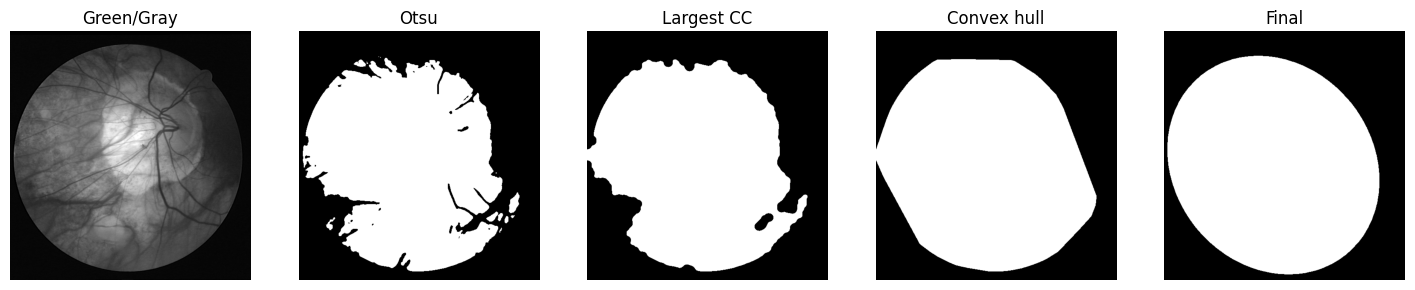

Chosen inverted: False
Scores: {'normal': 0.9268732731343579, 'inverted': -1.0021134258567514}
Ellipse used: True
Ellipse reason: fill_ratio_vs_centroid_circle=0.807 (<0.975), radial_cv=0.061, low_frac=0.468, r_pct=99.5


In [63]:
import cv2 as cv
from matplotlib import pyplot as plt
from pathlib import Path
import os

from fov_mask import compute_fov_mask

def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for _ in range(25):
        if (p / "images" / "input").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    raise FileNotFoundError("Couldn't find a folder containing images/input")

ROOT = find_project_root()  # <- keep this, DO NOT use .parent
print("cwd =", Path.cwd().resolve())
print("ROOT =", ROOT)

img_path = ROOT / "images" / "input" / "14.png"
print("img_path =", img_path)
print("exists? =", img_path.exists())

img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"OpenCV could not read: {img_path}")

mask, dbg = compute_fov_mask(
    img,
    close_ksize=21,
    open_ksize=11,
    do_convex_hull=True,
    ellipse_mode="auto",
    ellipse_scale=1.01,
    return_debug=True
)

plt.figure(figsize=(18,4))
plt.subplot(1,5,1); plt.title("Green/Gray");  plt.imshow(dbg.green_or_gray, cmap="gray"); plt.axis("off")
plt.subplot(1,5,2); plt.title("Otsu");        plt.imshow(dbg.otsu, cmap="gray");          plt.axis("off")
plt.subplot(1,5,3); plt.title("Largest CC");  plt.imshow(dbg.largest_cc, cmap="gray");    plt.axis("off")
plt.subplot(1,5,4); plt.title("Convex hull"); plt.imshow(dbg.convex_hull, cmap="gray");   plt.axis("off")
plt.subplot(1,5,5); plt.title("Final");       plt.imshow(mask, cmap="gray");              plt.axis("off")
plt.show()

print("Chosen inverted:", dbg.chosen_inverted)
print("Scores:", dbg.scores)
print("Ellipse used:", dbg.ellipse_used)
print("Ellipse reason:", dbg.ellipse_reason)
